# Parking Fun - fit model and predict

In [22]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import geocoder
import matplotlib.pyplot as plt

## Read in the processed the train and test data from csv files

In [23]:
train = pd.read_csv("../Archive/cleaned_train.csv")
test = pd.read_csv("../Archive/cleaned_test.csv")
pd.set_option('display.max_columns', 500)

In [24]:
train.head(1)

,Unnamed: 0,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,month,dayofweek,is_weekend
0,0,Mission Street,25th Street,26th Street,2014-01-07,16:19,4,179.13297,1,"Mission Street & 25th Street, San Francisco CA","Mission Street & 26th Street, San Francisco CA",37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16,1,1,0


In [25]:
test.head(1)

,Unnamed: 0,Street,From,To,Date,Time,Street.Length,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,month,dayofweek,is_weekend
0,0,Stockton Street,Stockton Tunnel,Clay Street,2014-03-28,16:34,35.786472,"Stockton Street & Stockton Tunnel, San Francis...","Stockton Street & Clay Street, San Francisco CA",37.792771,-122.407649,37.794064,-122.407922,37.793418,-122.407785,16,3,4,0


In [26]:
# Fix date format
train['Date'] = pd.to_datetime(train['Date'], infer_datetime_format=True)
test['Date'] = pd.to_datetime(test['Date'], infer_datetime_format=True)
print('Max date in train is {}'.format( train['Date'].max() ))
print('Min date in train is {}'.format( train['Date'].min() ))
print('Max date in test is {}'.format( test['Date'].max() ))
print('Min date in test is {}'.format( test['Date'].min() ))

Max date in train is 2014-03-28 00:00:00
Min date in train is 2014-01-07 00:00:00
Max date in test is 2016-11-04 00:00:00
Min date in test is 2014-03-28 00:00:00


In [27]:
#add block_id for each street-from-to combo
train['block_id'] = train.groupby(['Street','From','To']).ngroup()
test['block_id'] = test.groupby(['Street','From','To']).ngroup()
train['Street'] = train['Street'].apply(lambda x: x.lower())
test['Street'] = test['Street'].apply(lambda x: x.lower())

In [28]:
# save dataframe for later retrospec or debugging
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

# drop month column which doesn't help too much for training the model
drop_from_train_n_test = ['month']
train = train.drop(drop_from_train_n_test, axis=1)
test = test.drop(drop_from_train_n_test, axis=1)
train.rename(index=str, columns={"Unnamed: 0": "index"}, inplace=True)
test.rename(index=str, columns={"Unnamed: 0": "index"}, inplace=True)

In [16]:
train.head(1)

,index,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,dayofweek,is_weekend,block_id
0,0,mission street,25th Street,26th Street,2014-01-07,16:19,4,179.13297,1,"Mission Street & 25th Street, San Francisco CA","Mission Street & 26th Street, San Francisco CA",37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16,1,0,42


In [29]:
test.head(1)

,index,Street,From,To,Date,Time,Street.Length,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,dayofweek,is_weekend,block_id
0,0,stockton street,Stockton Tunnel,Clay Street,2014-03-28,16:34,35.786472,"Stockton Street & Stockton Tunnel, San Francis...","Stockton Street & Clay Street, San Francisco CA",37.792771,-122.407649,37.794064,-122.407922,37.793418,-122.407785,16,4,0,69


# Process Sensor table

In [30]:
df_sensor = pd.read_csv('../Archive/geocoded_sensor.csv')
df_sensor.rename(index=str, columns={"STREET_NAME": "Street", "DAY_TYPE":"is_weekend"}, inplace=True)
df_sensor = df_sensor.drop(['Unnamed: 0'], axis=1)
df_sensor['Date'] = pd.to_datetime(df_sensor['CAL_DATE'], infer_datetime_format=True)
df_sensor['hour'] = df_sensor['TIME_OF_DAY'].apply(lambda x: x/100).astype(int)
df_sensor['dayofweek'] = pd.to_datetime(df_sensor['Date']).dt.weekday
# df_sensor['is_weekend'] = ((pd.DatetimeIndex(df_sensor['Date']).dayofweek) // 5 == 1).astype(int)                   
# cal = calendar()
# holidays = cal.holidays()
# df_sensor['Holiday'] = df_sensor['Date'].isin(holidays)

In [31]:
df_sensor.head(1)

,BLOCK_ID,Street,BLOCK_NUM,STREET_BLOCK,AREA_TYPE,PM_DISTRICT_NAME,RATE,START_TIME_DT,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,CAL_MONTH_NAME,CAL_YEAR,CAL_DATE,is_weekend,TIME_OF_DAY,STREET_BLOCK_renamed,coord_block,block_lat,block_long,Date,hour,dayofweek
0,50001,jackson street,1.0,JACKSON ST 100,Pilot,Downtown,NaN,01-jul-2012 02:00:00,79200.0,39985.0,39215.0,0.0,0.0,0.0,0.0,0.0,79200.0,39985.0,39215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,July,2012.0,01-jul-2012,weekend,200.0,"JACKSON ST 100, San Francisco, CA","[37.7970989, -122.3983614]",37.797099,-122.398361,2012-07-01,2,6


In [32]:
df_sensor_new = df_sensor.copy()
df_sensor_new['TOTAL_VAC_RATIO'] = df_sensor['TOTAL_VACANT_TIME']/df_sensor['TOTAL_TIME']

cols_dropped_from_sensor = [
    'Date',
    'START_TIME_DT',
    'CAL_DATE',
    'STREET_BLOCK_renamed',
    'coord_block',
    'block_lat',
    'block_long',
    'RATE'
]
df_sensor_new = df_sensor_new.drop(cols_dropped_from_sensor, axis=1)

In [33]:
df_sensor_new.head(1)

,BLOCK_ID,Street,BLOCK_NUM,STREET_BLOCK,AREA_TYPE,PM_DISTRICT_NAME,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,CAL_MONTH_NAME,CAL_YEAR,is_weekend,TIME_OF_DAY,hour,dayofweek,TOTAL_VAC_RATIO
0,50001,jackson street,1.0,JACKSON ST 100,Pilot,Downtown,79200.0,39985.0,39215.0,0.0,0.0,0.0,0.0,0.0,79200.0,39985.0,39215.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,July,2012.0,weekend,200.0,2,6,0.495139


# Join train/test with sensor by street

In [154]:
cols_for_join = ['Street', 'dayofweek', 'hour']
train_sensor_merged = pd.merge(train, df_sensor_new, how='left', on = cols_for_join)
test_sensor_merged = pd.merge(test, df_sensor_new, how='left', on = cols_for_join)

train_sensor_merged.shape, train.shape, test_sensor_merged.shape, test.shape, df_sensor_new.shape

((657118, 51), (1100, 21), (434080, 49), (726, 19), (2197855, 33))

In [155]:
train_sensor_merged.head(1)

,index,Street,From,To,Date,Time,Real.Spots,Street.Length,any_spot,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,dayofweek,is_weekend_x,block_id,BLOCK_ID,BLOCK_NUM,STREET_BLOCK,AREA_TYPE,PM_DISTRICT_NAME,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,CAL_MONTH_NAME,CAL_YEAR,is_weekend_y,TIME_OF_DAY,TOTAL_VAC_RATIO
0,0,mission street,25th Street,26th Street,2014-01-07,16:19,4,179.13297,1,"Mission Street & 25th Street, San Francisco CA","Mission Street & 26th Street, San Francisco CA",37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16,1,0,42,56800,0.0,MISSION ST 0,Pilot,Downtown,97200.0,47489.0,17311.0,32400.0,57600.0,42074.0,15526.0,0.0,39600.0,5415.0,1785.0,32400.0,46800.0,37227.0,9573.0,0.0,10800.0,4847.0,5953.0,0.0,July,2012.0,weekday,1600.0,0.178097


# Join train/test with sensor by block_id (experiment only) 
The following code cells in the raw cells were only for the purpose of experimenting another way of joining the `train`/`test` dataset with `senser` dataset, by `block_id`. This method has already been proved to be less effective than joining them by `street` which is mentioned above.

**If you want to run these pieces of codes, pls. turn off the code enclosed under section "Join train/test with sensor by street" above**

In [156]:
# block_train = train[['block_id',
#                     'Street.Length',
#                     'from_lat', 
#                     'from_long', 
#                     'to_lat',
#                     'to_long',
#                     'block_lat',
#                     'block_long']]
# block_train.drop_duplicates(inplace=True)
# block_train.rename(index=str, columns={"Street.Length": "StreetLength"}, inplace=True)

# block_test = test[['block_id',
#                     'Street.Length',
#                     'from_lat', 
#                     'from_long', 
#                     'to_lat',
#                     'to_long',
#                     'block_lat',
#                     'block_long']]
# block_test.drop_duplicates(inplace=True)
# block_test.rename(index=str, columns={"Street.Length": "StreetLength"}, inplace=True)

# sensor_BLOCK_info = df_sensor[[
#     'BLOCK_ID',
#     'block_lat',
#     'block_long'
# ]]
# sensor_BLOCK_info.drop_duplicates(inplace=True)

# block_train.shape, block_test.shape, sensor_BLOCK_info.shape

In [157]:
# from geopy.distance import great_circle
# import geopy
# def map_to_train_block(row):
#     ret_row = row.copy()
#     for r in block_train.itertuples():
#         center_coord = (r.block_lat, r.block_long)
#         block_coord = (row['block_lat'], row['block_long'])
#         dist = great_circle(center_coord, block_coord).meters
        
#         if (r.StreetLength / 2 - dist > 0.0):
#             ret_row['block_id'] = r.block_id
#             break
#     return ret_row
        
# sensor_BLOCK_info['block_id'] = np.nan
# sensor_BLOCK_info_train = sensor_BLOCK_info.copy()
# sensor_BLOCK_info_train = sensor_BLOCK_info_train.apply(map_to_train_block, axis=1)
# BLOCK_block_map_train = sensor_BLOCK_info_train.drop(['block_lat', 'block_long'], axis = 1)
# BLOCK_block_map_train = BLOCK_block_map_train[BLOCK_block_map_train['block_id'].isna()==False]

# sensor_w_block_id_train = pd.merge(df_sensor_new, BLOCK_block_map_train, how='inner', on = 'BLOCK_ID')

In [158]:
# sensor_w_block_id_train.shape, df_sensor_new.shape

In [159]:
# def map_to_test_block(row):
#     ret_row = row.copy()
#     for r in block_test.itertuples():
#         center_coord = (r.block_lat, r.block_long)
#         block_coord = (row['block_lat'], row['block_long'])
#         dist = great_circle(center_coord, block_coord).meters
#         if (r.StreetLength / 2 - dist > 0.0):
#             ret_row['block_id'] = r.block_id
#             break
#     return ret_row
        

# sensor_BLOCK_info_test = sensor_BLOCK_info.copy()
# sensor_BLOCK_info_test = sensor_BLOCK_info_test.apply(map_to_test_block, axis=1)
# BLOCK_block_map_test = sensor_BLOCK_info_test.drop(['block_lat', 'block_long'], axis = 1)
# BLOCK_block_map_test = BLOCK_block_map_test[BLOCK_block_map_test['block_id'].isna()==False]

# sensor_w_block_id_test = pd.merge(df_sensor_new, BLOCK_block_map_test, how='inner', on = 'BLOCK_ID')

In [160]:
# sensor_w_block_id_test.shape,BLOCK_block_map_test.shape, df_sensor_new.shape

In [161]:
# cols_for_join = ['block_id', 'hour',   'dayofweek'] # ,'month', 'Holiday', 'is_weekend']

# train_sensor_merged = pd.merge(train, sensor_w_block_id_train, how='left', on = cols_for_join)
# test_sensor_merged = pd.merge(test, sensor_w_block_id_test, how='left', on = cols_for_join)

In [162]:
# train_sensor_merged.isnull().sum()

# Process the merged dataset

In [163]:
cols_dropped_from_merge = [
    'CAL_MONTH_NAME',
    'Date',
    'Time',
    'TIME_OF_DAY',
    'CAL_YEAR'
]
train_sensor_merged = train_sensor_merged.drop(cols_dropped_from_merge, axis=1)
test_sensor_merged = test_sensor_merged.drop(cols_dropped_from_merge, axis=1)

In [164]:
train_sensor_merged.head(1)

,index,Street,From,To,Real.Spots,Street.Length,any_spot,street_from,street_to,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour,dayofweek,is_weekend_x,block_id,BLOCK_ID,BLOCK_NUM,STREET_BLOCK,AREA_TYPE,PM_DISTRICT_NAME,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,is_weekend_y,TOTAL_VAC_RATIO
0,0,mission street,25th Street,26th Street,4,179.13297,1,"Mission Street & 25th Street, San Francisco CA","Mission Street & 26th Street, San Francisco CA",37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16,1,0,42,56800,0.0,MISSION ST 0,Pilot,Downtown,97200.0,47489.0,17311.0,32400.0,57600.0,42074.0,15526.0,0.0,39600.0,5415.0,1785.0,32400.0,46800.0,37227.0,9573.0,0.0,10800.0,4847.0,5953.0,0.0,weekday,0.178097


In [165]:
# convert the columns with object type to be numeric

def proc_col(col):
    """Encodes a pandas column with continous ids. 
    """
    uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return np.array([name2idx[x] for x in col])

cols_str_2_num = [
    'Street',
    'From',
    'To',
    'street_from',
    'street_to',
    'STREET_BLOCK',
    'AREA_TYPE',
    'PM_DISTRICT_NAME'
]

for col in cols_str_2_num:
    train_sensor_merged[col+'_num'] = proc_col(train_sensor_merged[col])
    test_sensor_merged[col+'_num'] = proc_col(test_sensor_merged[col])

# drop the columns which were just covertered to new num columns
train_sensor_merged = train_sensor_merged.drop(cols_str_2_num, axis=1)
test_sensor_merged = test_sensor_merged.drop(cols_str_2_num, axis=1)

In [166]:
# Make sure there is no NaN in the data

train_sensor_merged.isnull().sum()

index                   0
Real.Spots              0
Street.Length           0
any_spot                0
from_lat                0
from_long               0
to_lat                  0
to_long                 0
block_lat               0
block_long              0
hour                    0
dayofweek               0
is_weekend_x            0
block_id                0
BLOCK_ID                0
BLOCK_NUM               0
TOTAL_TIME              0
TOTAL_OCCUPIED_TIME     0
TOTAL_VACANT_TIME       0
TOTAL_UNKNOWN_TIME      0
OP_TIME                 0
OP_OCCUPIED_TIME        0
OP_VACANT_TIME          0
OP_UNKNOWN_TIME         0
NONOP_TIME              0
NONOP_OCCUPIED_TIME     0
NONOP_VACANT_TIME       0
NONOP_UNKNOWN_TIME      0
GMP_TIME                0
GMP_OCCUPIED_TIME       0
GMP_VACANT_TIME         0
GMP_UNKNOWN_TIME        0
COMM_TIME               0
COMM_OCCUPIED_TIME      0
COMM_VACANT_TIME        0
COMM_UNKNOWN_TIME       0
is_weekend_y            0
TOTAL_VAC_RATIO         0
Street_num  

In [167]:
# Make sure there is no NaN in the data
test_sensor_merged.isnull().sum()

index                   0
Street.Length           0
from_lat                0
from_long               0
to_lat                  0
to_long                 0
block_lat               0
block_long              0
hour                    0
dayofweek               0
is_weekend_x            0
block_id                0
BLOCK_ID                0
BLOCK_NUM               0
TOTAL_TIME              0
TOTAL_OCCUPIED_TIME     0
TOTAL_VACANT_TIME       0
TOTAL_UNKNOWN_TIME      0
OP_TIME                 0
OP_OCCUPIED_TIME        0
OP_VACANT_TIME          0
OP_UNKNOWN_TIME         0
NONOP_TIME              0
NONOP_OCCUPIED_TIME     0
NONOP_VACANT_TIME       0
NONOP_UNKNOWN_TIME      0
GMP_TIME                0
GMP_OCCUPIED_TIME       0
GMP_VACANT_TIME         0
GMP_UNKNOWN_TIME        0
COMM_TIME               0
COMM_OCCUPIED_TIME      0
COMM_VACANT_TIME        0
COMM_UNKNOWN_TIME       0
is_weekend_y            0
TOTAL_VAC_RATIO         0
Street_num              0
From_num                0
To_num      

In [168]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, accuracy_score, fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [169]:
# Calculate the mean for all the columns based on the grouping by
# index which originates from the train/test datasets

train2 = train_sensor_merged.groupby('index')[train_sensor_merged.columns.values].mean()
test2 = test_sensor_merged.groupby('index')[test_sensor_merged.columns.values].mean()

## Read in the parkingrecord csv file, i.e the meter info

In [171]:
parking_rec_df = pd.read_csv('../project-data/parkingrecords.csv')
parking_rec_df.columns

Index(['lat', 'lon', 'datetime'], dtype='object')

In [172]:
parking_rec_df['DateTime']  = pd.to_datetime(parking_rec_df['datetime'], unit='ms')
parking_rec_df['DateTime'] = pd.to_datetime(parking_rec_df['DateTime'], infer_datetime_format=True)
parking_rec_df['DateTime'] = parking_rec_df['DateTime'].apply(lambda x: x.replace(microsecond=0))
parking_rec_df['hour'] = pd.to_datetime(parking_rec_df['DateTime'], format='%Y-%m-%d %H:%M:%S').dt.hour
parking_rec_df['dayofweek'] = pd.to_datetime(parking_rec_df['DateTime'], format="%Y-%m-%d %H:%M:%S").dt.weekday
parking_rec_df = parking_rec_df.drop(['datetime', 'DateTime'], axis=1)

In [173]:
parking_rec_df.head(1)

,lat,lon,hour,dayofweek
0,37.771637,-122.437112,15,1


In [174]:
parking_rec_df.shape

(1761328, 4)

In [175]:
# remove the duplicated rows in order to save time
parking_rec_df.drop_duplicates(inplace=True)
parking_rec_df.shape

(884291, 4)

In [176]:
parking_rec_df['block_id'] = np.nan
parking_rec_df['occurance'] = 1

## Compute the `block_id` for each given meter against the TRAIN dataset
**The else branch takes 1 hour to finish because of the length (884291) of the meter dataset**
So we save the result dataset `parking_rec_df_train_nona` to a csv file after the first time execution and upload it to the code repo for later-on. This is why code below checks the existance of that csv file.

In [177]:
import os
from geopy.distance import great_circle
import geopy

block_info = train[['block_id',
                    'Street.Length',
                    'from_lat', 
                    'from_long', 
                    'to_lat',
                    'to_long']]
block_info.drop_duplicates(inplace=True)
block_info.rename(index=str, columns={"Street.Length": "StreetLength"}, inplace=True)

def get_block_id(row):
    ret_row = row.copy()
    for r in block_info.itertuples():
        meter_loc = (row['lat'], row['lon'])
        intersec_from = (r.from_lat, r.from_long)
        intersec_to = (r.to_lat, r.to_long)
        dist_to_intersec_from = great_circle(meter_loc, intersec_from).meters
        dist_to_intersec_to = great_circle(meter_loc, intersec_to).meters

        if (dist_to_intersec_from + dist_to_intersec_to < r.StreetLength * 1.2):
            ret_row['block_id'] = r.block_id
            break
    return ret_row


parking_rec_df_train_nona_file = 'parking_rec_df_train_nona.csv'

if os.path.isfile(parking_rec_df_train_nona_file):
    parking_rec_df_train_nona = pd.read_csv(parking_rec_df_train_nona_file)
else:
    parking_rec_df_train = parking_rec_df.copy()
    parking_rec_df_train = parking_rec_df_train.apply(get_block_id, axis=1)
    parking_rec_df_train_nona = parking_rec_df_train[parking_rec_df_train['block_id'].isna()==False]
    parking_rec_df_train_nona['block_id'] = parking_rec_df_train_nona['block_id'].astype(int)
    parking_rec_df_train_nona.to_csv(parking_rec_df_train_nona_file, index=False)

In [178]:
block_info.shape, parking_rec_df_train_nona.shape

((99, 6), (36271, 6))

In [179]:
parking_rec_df_train_nona.head(1)

,lat,lon,hour,dayofweek,block_id,occurance
0,37.750277,-122.417876,2.0,6.0,42,1.0


## Compute the `block_id` for each given meter against the TEST data
**The same concept as above for building another dataframe which computed `block_id`**, because we shouldn't assume that the auto-generated index in test dataframe indicates the same street block as train dataset.
**AGAIN, The else branch takes 1 hour to finish because of the length (884291) of the meter dataset**

In [180]:
from geopy.distance import great_circle
import geopy

block_info_test = test[['block_id',
                    'Street.Length',
                    'from_lat', 
                    'from_long', 
                    'to_lat',
                    'to_long']]
block_info_test.drop_duplicates(inplace=True)
block_info_test.rename(index=str, columns={"Street.Length": "StreetLength"}, inplace=True)

def get_block_id_test(row): 
    ret_row = row.copy()
    for r in block_info_test.itertuples():
        meter_loc = (row['lat'], row['lon'])
        intersec_from = (r.from_lat, r.from_long)
        intersec_to = (r.to_lat, r.to_long)
        dist_to_intersec_from = great_circle(meter_loc, intersec_from).meters
        dist_to_intersec_to = great_circle(meter_loc, intersec_to).meters

        if (dist_to_intersec_from + dist_to_intersec_to < 1.2 * r.StreetLength ):
            ret_row['block_id'] = r.block_id
            break
    return ret_row

parking_rec_df_test_nona_file = 'parking_rec_df_test_nona.csv'


if os.path.isfile(parking_rec_df_test_nona_file):
    parking_rec_df_test_nona = pd.read_csv(parking_rec_df_test_nona_file)
else:
    parking_rec_df_test = parking_rec_df.copy()
    parking_rec_df_test['block_id'] = np.nan
    parking_rec_df_test['occurance'] = 1
    parking_rec_df_test = parking_rec_df_test.apply(get_block_id_test, axis=1)
    parking_rec_df_test_nona = parking_rec_df_test[parking_rec_df_test['block_id'].isna()==False]
    parking_rec_df_test_nona['block_id'] = parking_rec_df_test_nona['block_id'].astype(int)
    parking_rec_df_test_nona.to_csv(parking_rec_df_test_nona_file, index=False)

In [181]:
block_info_test.shape, parking_rec_df_test_nona.shape

((99, 6), (36271, 6))

In [182]:
parking_rec_df_test_nona.head(1)

,lat,lon,hour,dayofweek,block_id,occurance
0,37.750277,-122.417876,2.0,6.0,42,1.0


In [183]:
# compute the number of occurance of a meter when it is set at a 
# given time (specified by: 'dayofweek' &'hour')
c4j_2 = ['block_id', 'dayofweek', 'hour']

col1  = parking_rec_df_train_nona.groupby(c4j_2, as_index=False).size()
parking_rec_df_train_nona_agg = pd.DataFrame({'counter': col1}).reset_index()

col2 = parking_rec_df_test_nona.groupby(c4j_2, as_index=False).size()
parking_rec_df_test_nona_agg = pd.DataFrame({'counter': col2}).reset_index()

In [184]:
parking_rec_df_train_nona_agg.head(4)

,block_id,dayofweek,hour,counter
0,0,0.0,7.0,1
1,0,0.0,8.0,1
2,0,0.0,9.0,3
3,0,0.0,10.0,4


# Join the meter dataset to the previously joint dataset by `block_id`
Now Train/Test, Sensor and Meter are joined together.

In [185]:
train2_meter_merged = pd.merge(train2, parking_rec_df_train_nona_agg, how='left', on =  ['block_id'])
test2_meter_merged = pd.merge(test2, parking_rec_df_test_nona_agg, how='left', on = ['block_id'])

In [186]:
train2_meter_merged.head(4)

,index,Real.Spots,Street.Length,any_spot,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour_x,dayofweek_x,is_weekend_x,block_id,BLOCK_ID,BLOCK_NUM,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,TOTAL_VAC_RATIO,Street_num,From_num,To_num,street_from_num,street_to_num,STREET_BLOCK_num,AREA_TYPE_num,PM_DISTRICT_NAME_num,dayofweek_y,hour_y,counter
0,0.0,4.0,179.13297,1.0,37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16.0,1.0,0.0,42,56813.797297,13.797297,99330.810811,54284.208108,20989.845946,24056.756757,72262.702703,52044.593243,19619.731081,598.378378,27068.108108,2239.614865,1370.114865,23458.378378,58402.702703,44892.981081,13028.1,481.621622,13860.0,7151.612162,6591.631081,116.756757,0.224337,0.0,0.0,0.0,0.0,0.0,3.891892,0.0,0.545946,0.0,7.0,1.0
1,0.0,4.0,179.13297,1.0,37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16.0,1.0,0.0,42,56813.797297,13.797297,99330.810811,54284.208108,20989.845946,24056.756757,72262.702703,52044.593243,19619.731081,598.378378,27068.108108,2239.614865,1370.114865,23458.378378,58402.702703,44892.981081,13028.1,481.621622,13860.0,7151.612162,6591.631081,116.756757,0.224337,0.0,0.0,0.0,0.0,0.0,3.891892,0.0,0.545946,0.0,8.0,9.0
2,0.0,4.0,179.13297,1.0,37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16.0,1.0,0.0,42,56813.797297,13.797297,99330.810811,54284.208108,20989.845946,24056.756757,72262.702703,52044.593243,19619.731081,598.378378,27068.108108,2239.614865,1370.114865,23458.378378,58402.702703,44892.981081,13028.1,481.621622,13860.0,7151.612162,6591.631081,116.756757,0.224337,0.0,0.0,0.0,0.0,0.0,3.891892,0.0,0.545946,0.0,9.0,28.0
3,0.0,4.0,179.13297,1.0,37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16.0,1.0,0.0,42,56813.797297,13.797297,99330.810811,54284.208108,20989.845946,24056.756757,72262.702703,52044.593243,19619.731081,598.378378,27068.108108,2239.614865,1370.114865,23458.378378,58402.702703,44892.981081,13028.1,481.621622,13860.0,7151.612162,6591.631081,116.756757,0.224337,0.0,0.0,0.0,0.0,0.0,3.891892,0.0,0.545946,0.0,10.0,30.0


In [187]:
train2_meter_merged.shape

(55676, 48)

In [188]:
# Calculate the mean for all the columns based on the grouping by
# index which originates from the train/test datasets
train2_meter_merged = train2_meter_merged.groupby('index')[train2_meter_merged.columns.values].mean()
test2_meter_merged = test2_meter_merged.groupby('index')[test2_meter_merged.columns.values].mean()
train2_meter_merged = train2_meter_merged.drop(['index'], axis=1)
test2_meter_merged = test2_meter_merged.drop(['index'], axis=1)

In [189]:
train2_meter_merged.head(1)

,Real.Spots,Street.Length,any_spot,from_lat,from_long,to_lat,to_long,block_lat,block_long,hour_x,dayofweek_x,is_weekend_x,BLOCK_ID,BLOCK_NUM,TOTAL_TIME,TOTAL_OCCUPIED_TIME,TOTAL_VACANT_TIME,TOTAL_UNKNOWN_TIME,OP_TIME,OP_OCCUPIED_TIME,OP_VACANT_TIME,OP_UNKNOWN_TIME,NONOP_TIME,NONOP_OCCUPIED_TIME,NONOP_VACANT_TIME,NONOP_UNKNOWN_TIME,GMP_TIME,GMP_OCCUPIED_TIME,GMP_VACANT_TIME,GMP_UNKNOWN_TIME,COMM_TIME,COMM_OCCUPIED_TIME,COMM_VACANT_TIME,COMM_UNKNOWN_TIME,TOTAL_VAC_RATIO,Street_num,From_num,To_num,street_from_num,street_to_num,STREET_BLOCK_num,AREA_TYPE_num,PM_DISTRICT_NAME_num,dayofweek_y,hour_y,counter
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,4.0,179.13297,1.0,37.750648,-122.418316,37.749044,-122.418166,37.749846,-122.418241,16.0,1.0,0.0,56813.797297,13.797297,99330.810811,54284.208108,20989.845946,24056.756757,72262.702703,52044.593243,19619.731081,598.378378,27068.108108,2239.614865,1370.114865,23458.378378,58402.702703,44892.981081,13028.1,481.621622,13860.0,7151.612162,6591.631081,116.756757,0.224337,0.0,0.0,0.0,0.0,0.0,3.891892,0.0,0.545946,2.987342,12.658228,25.455696


In [190]:
train2_meter_merged.isnull().sum()

Real.Spots                0
Street.Length             0
any_spot                  0
from_lat                  0
from_long                 0
to_lat                    0
to_long                   0
block_lat                 0
block_long                0
hour_x                    0
dayofweek_x               0
is_weekend_x              0
BLOCK_ID                  0
BLOCK_NUM                 0
TOTAL_TIME                0
TOTAL_OCCUPIED_TIME       0
TOTAL_VACANT_TIME         0
TOTAL_UNKNOWN_TIME        0
OP_TIME                   0
OP_OCCUPIED_TIME          0
OP_VACANT_TIME            0
OP_UNKNOWN_TIME           0
NONOP_TIME                0
NONOP_OCCUPIED_TIME       0
NONOP_VACANT_TIME         0
NONOP_UNKNOWN_TIME        0
GMP_TIME                  0
GMP_OCCUPIED_TIME         0
GMP_VACANT_TIME           0
GMP_UNKNOWN_TIME          0
COMM_TIME                 0
COMM_OCCUPIED_TIME        0
COMM_VACANT_TIME          0
COMM_UNKNOWN_TIME         0
TOTAL_VAC_RATIO           0
Street_num          

In [191]:
test2_meter_merged.isnull().sum()

Street.Length             0
from_lat                  0
from_long                 0
to_lat                    0
to_long                   0
block_lat                 0
block_long                0
hour_x                    0
dayofweek_x               0
is_weekend_x              0
BLOCK_ID                  0
BLOCK_NUM                 0
TOTAL_TIME                0
TOTAL_OCCUPIED_TIME       0
TOTAL_VACANT_TIME         0
TOTAL_UNKNOWN_TIME        0
OP_TIME                   0
OP_OCCUPIED_TIME          0
OP_VACANT_TIME            0
OP_UNKNOWN_TIME           0
NONOP_TIME                0
NONOP_OCCUPIED_TIME       0
NONOP_VACANT_TIME         0
NONOP_UNKNOWN_TIME        0
GMP_TIME                  0
GMP_OCCUPIED_TIME         0
GMP_VACANT_TIME           0
GMP_UNKNOWN_TIME          0
COMM_TIME                 0
COMM_OCCUPIED_TIME        0
COMM_VACANT_TIME          0
COMM_UNKNOWN_TIME         0
TOTAL_VAC_RATIO           0
Street_num                0
From_num                  0
To_num              

In [192]:
# Fill NA with mean
mean = train2_meter_merged.counter.mean()
train2_meter_merged['counter'].fillna(mean, inplace=True)
mean_hour = train2_meter_merged.hour_y.mean()
train2_meter_merged['hour_y'].fillna(mean_hour, inplace=True)
mean_dow_y = train2_meter_merged.dayofweek_y.mean()
train2_meter_merged['dayofweek_y'].fillna(mean_dow_y, inplace=True)

mean = test2_meter_merged.counter.mean()
test2_meter_merged['counter'].fillna(mean, inplace=True)
mean_hour = test2_meter_merged.hour_y.mean()
test2_meter_merged['hour_y'].fillna(mean_hour, inplace=True)
mean_dow_y = test2_meter_merged.dayofweek_y.mean()
test2_meter_merged['dayofweek_y'].fillna(mean_dow_y, inplace=True)

## `train_final` is the final train data for training the data
## `test_final` is the final test set for running the prediction

In [345]:
train_final = train2_meter_merged.copy()
test_final = test2_meter_merged.copy()

In [346]:
# Columns that could be used later on for tuning purpose. (Experiments only)
drop_lot_more_cols = False

if drop_lot_more_cols == True:
    drop_before_modeling_tier_1 = [
        'from_lat',
        'from_long',
        'to_lat',
        'to_long',
        'block_lat',
        'block_long',
        'BLOCK_NUM'
    ]
    drop_before_modeling_tier_2 = [
        'Street_num',
        'From_num',
        'To_num',
        'street_from_num',
        'street_to_num',
        'STREET_BLOCK_num'
    ]
    train_final = train_final.drop(drop_before_modeling_tier_1, axis=1)
    test_final = test_final.drop(drop_before_modeling_tier_1, axis=1)
    train_final = train_final.drop(drop_before_modeling_tier_2, axis=1)
    test_final = test_final.drop(drop_before_modeling_tier_2, axis=1)

## !!!!!!! TRAIN The model !!!!!!!!

In [348]:
X = train_final.drop(['any_spot', 'Real.Spots'], axis=1)
y = train_final['any_spot']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [349]:
train_final.shape, test_final.shape, X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1100, 46), (726, 44), (880, 44), (220, 44), (880,), (220,))

## Mean encoding based on the final train/test (for experimenting)
Turning it off gets better score than turning it on.

In [350]:
mean_encoding_flag = False

def mean_encoding(traintrain, valval, testtest, col):
    mean_col = traintrain.groupby(col).any_spot.mean()
    global_mean = traintrain.any_spot.mean()
    
    new_col_name = col + '_mean_enc'
    
    traintrain[new_col_name] = traintrain[col].map(mean_col)
    traintrain[new_col_name].fillna(global_mean, inplace=True)
    traintrain[new_col_name] = traintrain[new_col_name].astype(np.float16)
    
    valval[new_col_name] = valval[col].map(mean_col)
    valval[new_col_name].fillna(global_mean, inplace=True)
    valval[new_col_name] = valval[new_col_name].astype(np.float16)
    
    testtest[new_col_name] = testtest[col].map(mean_col)
    testtest[new_col_name].fillna(global_mean, inplace=True)
    testtest[new_col_name] = testtest[new_col_name].astype(np.float16)

if mean_encoding_flag == True:
    cols_for_mean_enc = [ 'hour_x',
                         'dayofweek_x',
                         'BLOCK_ID',
                         'BLOCK_NUM',
                         'Street_num',
                         'From_num',
                         'To_num',
                         'street_from_num',
                         'street_to_num',
                         'STREET_BLOCK_num',
                         'AREA_TYPE_num',
                         'PM_DISTRICT_NAME_num',
                         'dayofweek_y',
                         'hour_y']

    train_for_mean_enc = X_train
    train_for_mean_enc['any_spot'] = y_train
    val_for_mean_enc = X_val
    val_for_mean_enc['any_spot'] = y_val

    for col in cols_for_mean_enc:
        mean_encoding(train_for_mean_enc, val_for_mean_enc, test_final, col)

    y_train = train_for_mean_enc['any_spot']
    X_train = train_for_mean_enc.drop(cols_for_mean_enc + ['any_spot'], axis=1)
    y_val = val_for_mean_enc['any_spot']
    X_val = val_for_mean_enc.drop(cols_for_mean_enc + ['any_spot'], axis=1)
    test_final = test_final.drop(cols_for_mean_enc, axis=1)

In [351]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((880, 44), (220, 44), (880,), (220,))

## Leverage GridSearch for fitting the Random Forest Classifier

In [352]:
from sklearn.metrics import fbeta_score, make_scorer

model = RandomForestClassifier()

parameters = {
    "n_estimators" :  [1, 50, 80, 100, 200, 400, 600, 800],
    "max_depth" :  [1, 5, 10, 20, 30, 50, 100],
    "min_samples_leaf" : [1, 2, 5, 10],
    "max_features": [None, 'log2', 'sqrt']
}

f_point5_scorer = make_scorer(fbeta_score, beta=0.5)

gsc = GridSearchCV(model, parameters, n_jobs=-1,verbose=1, scoring=f_point5_scorer)
# gsc.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val])) # the full training set
gsc.fit(X_train, y_train)
best_parameters, score, _ = max(gsc.grid_scores_, key=lambda x: x[1])
print(best_parameters)
print(score)

Fitting 3 folds for each of 672 candidates, totalling 2016 fits


[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 623 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 973 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1423 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2016 out of 2016 | elapsed:  5.4min finished


{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'n_estimators': 600}
0.6035069929759231


In [353]:
from sklearn.model_selection import cross_val_score

# Could be the best
# max_depth_best = 30
# min_samples_leaf_best = 10
# n_estimator_best = 800

max_depth_best = best_parameters['max_depth']
min_samples_leaf_best = best_parameters['min_samples_leaf']
n_estimator_best = best_parameters['n_estimators']
max_features_best = best_parameters['max_features']

m = RandomForestClassifier(max_depth=max_depth_best,
                           min_samples_leaf=min_samples_leaf_best, 
                           n_estimators=n_estimator_best, 
                           max_features=max_features_best,
                           n_jobs=-1)

scores = cross_val_score(m, 
                         pd.concat([X_train, X_val]),
                         pd.concat([y_train, y_val]),
                         scoring=f_point5_scorer,
                         cv=7)
print("Cross Scores: %s" % scores)
print("Cross Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

m.fit(X_train, y_train)
y_pred_val = m.predict(X_val)
print("F0.5 score: %f" % fbeta_score(y_val, y_pred_val, 0.5))

Cross Scores: [0.67518248 0.64569536 0.6        0.59183673 0.61032864 0.6097561
 0.62256809]
Cross Accuracy: 0.62 (+/- 0.05)
F0.5 score: 0.625000


In [354]:
import pandas as pd

y_pred_test = m.predict(test_final)
df = pd.DataFrame(y_pred_test.astype(int))
df.index = df.index+1
df = df.reset_index()
df.columns = ["id", "any_spot"]
df.to_csv("list_grid.csv", index=False)

In [355]:
df.describe()

,id,any_spot
count,726.000000,726.000000
mean,363.500000,0.260331
std,209.722436,0.439117
min,1.000000,0.000000
25%,182.250000,0.000000
50%,363.500000,0.000000
75%,544.750000,1.000000
max,726.000000,1.000000


## Compute the precision and recall

Average precision-recall score: 0.51


Text(0.5,1,'2-class Precision-Recall curve: AP=0.51')

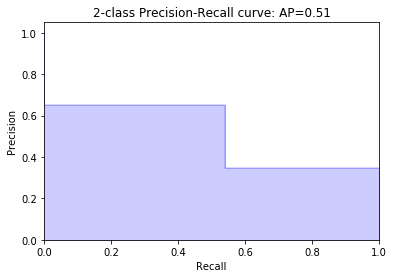

In [356]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

average_precision = average_precision_score(y_val, y_pred_val)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
plt.step(recall, precision, color='b', alpha=0.2,where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))